In [1]:
from PathGenerate import fbmResample
from HFBMPerformance import fbmHcheck
from fbm import FBM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
return_data = pd.read_csv('price.csv')
return_data

,^GSPC,^DJI,AAPL,T,GE,KO,MCD,JNJ,SBUX,V,NKE,COST
0,2510.030029,23346.240234,38.105133,15.942037,60.908718,41.413994,160.380203,114.965172,59.440094,129.483688,71.284409,193.152710
1,2447.889893,22686.220703,34.309586,15.963625,60.984379,41.158066,159.323486,113.138336,56.861763,124.817535,70.023506,189.058762
2,2531.939941,23433.160156,35.774235,16.373777,62.270645,41.978767,162.402466,115.037170,58.746990,130.194809,71.852303,194.548859
3,2549.689941,23531.349609,35.694614,16.670601,66.129463,41.431644,164.169739,114.299217,58.746990,132.542496,72.882195,195.265747
4,2574.409912,23787.449219,36.375065,16.881077,64.767525,41.899342,164.515854,116.954002,58.793194,133.263367,73.854362,196.727905
...,...,...,...,...,...,...,...,...,...,...,...,...
246,3224.010010,28551.529297,69.557121,22.863737,88.170143,49.991432,183.039932,135.499664,83.067078,183.412918,97.310539,279.400665
247,3223.379883,28515.449219,69.623230,22.799364,88.407158,49.809349,183.478424,135.027725,83.340111,183.893326,97.407822,280.277069
248,3239.909912,28621.390625,71.004578,22.916409,88.723167,50.091576,183.842255,134.935211,82.925858,185.452164,97.962257,281.705963
249,3240.020020,28645.259766,70.977631,22.963221,88.328148,50.392025,184.877808,134.861191,82.972946,185.677612,98.798790,280.162720


## Test 1: Hurst test

In [3]:
# For the given stock price, separate into two parts with 4 Hurst exponent: 
# 1: The total data which contains 251 day's price:
#     1) estimate H directly with the given path: H true;
# 2: The first 60 day's price:
#     1) estimate H directly with the given path: H traditional;
#     2) estimate H with the path extending 60 to 200 by using straight minus distance: H straight minus;
#     3) generate 60 paths with length 200, connecting their increment to a long path, then estimate H: H normal;

def check_res(path):
    path_shape = (2,30)
    path = np.asarray(path)
    sample_60 = path[:61]
    
    orig_est = fbmHcheck(path)
    orig_H = orig_est.H_est()
    
    first60_est = fbmHcheck(sample_60)
    first60_H = first60_est.H_est()

    direct_est = fbmResample(sample_60,path_shape, 1)
    direct_path = direct_est.path_generate()
    direct_check = fbmHcheck(direct_path)
    direct_H = direct_check.H_est()
    
    
    pred_pat = []
    for i in range(60):
        est = fbmResample(sample_60, path_shape, 2, 100)
        path_new = est.path_generate()
        path_increment = path_new[1:] - path_new[:-1]
        pred_pat = pred_pat + path_increment.tolist()
    est = fbmResample(sample_60, path_shape, 1)
    pred_pat = est.back_fbm(np.asarray(pred_pat))
    H_new = fbmHcheck(pred_pat)

    return [orig_H, first60_H, direct_H, H_new.H_est()]

In [4]:
# For each given stock price, esmate Hurst with the first 60 day's price
T_H, top_60_trid, top_60_sta, top_60_norm = [],[],[],[]
for pat_ind in return_data.columns:
    path = np.asarray(return_data[pat_ind])
    T_H_temp, top_60_trid_temp, top_60_sta_temp, top_60_norm_temp = check_res(path)
    T_H.append(T_H_temp)
    top_60_trid.append(top_60_trid_temp) 
    top_60_sta.append(top_60_sta_temp) 
    top_60_norm.append(top_60_norm_temp)

In [5]:
T_H = np.array(T_H)
top_60_trid = np.array(top_60_trid)
top_60_norm = np.array(top_60_norm)
top_60_sta = np.array(top_60_sta)

stock_index = list(return_data.columns)
map_index = ['SP500','DJ30','AAPL','AT&T', 
             'GE', 'KO', 'MCD', 'JNJ', 'SBUX', 
             'V', 'NKE', 'COST']

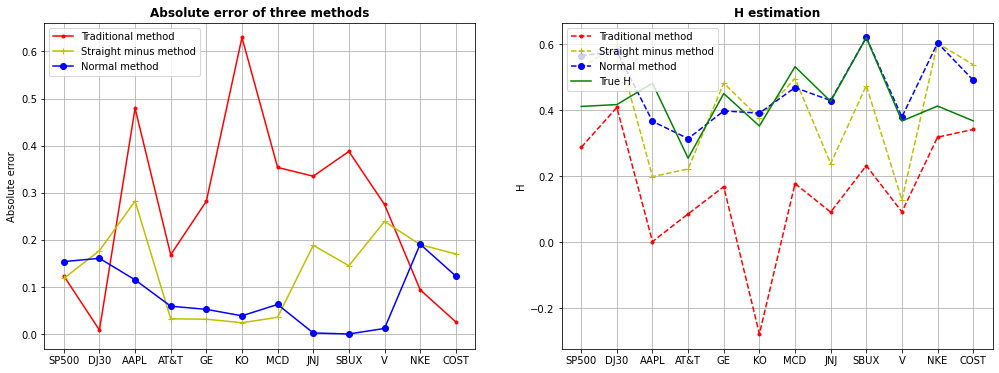

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(17, 6))

ax1.plot(map_index, np.abs(T_H - top_60_trid),'.-r', label='Traditional method')
ax1.plot(map_index, np.abs(T_H - top_60_sta),'+-y', label='Straight minus method')
ax1.plot(map_index, np.abs(T_H - top_60_norm),'o-b', label='Normal method')
ax1.set_xticks(map_index, rotation=45)

ax1.set_ylabel('Absolute error')
ax1.set_title('Absolute error of three methods', fontweight='bold')
ax1.grid()
ax1.legend(loc='upper left')

ax2.plot(map_index, top_60_trid, '.--r', label='Traditional method')
ax2.plot(map_index, top_60_sta,'+--y', label='Straight minus method')
ax2.plot(map_index, top_60_norm,'o--b', label='Normal method')

ax2.plot(T_H,'g', label='True H')
ax2.set_ylabel('H')
ax2.set_title('H estimation', fontweight='bold')
ax2.grid()
ax2.legend(loc='upper left')

plt.savefig('Example_H.jpg', dpi=300)

## Test 2: FBM pass rate

In [7]:
# Input the price of one stock, path shape, the output length, 
# signal parameter m, distanec type, and estimated Hurst
def ispass(path, path_shape, output_length, sig_m, distance, H):
    # Using the log return of one day's price
    path = np.asarray(np.log(path) - np.mean(np.log(path)))
    
    model = fbmResample(path, path_shape, distance, output_length, sig_m)
    new_path = model.path_generate()
    pass_model = fbmHcheck(new_path, 40,H)
    return pass_model.fbm_test()

In [8]:
# One example of GE stock price with path reshape 5*50 and output length 155
path = return_data['GE']
H_GE = fbmHcheck(path).H_est()

print(f'New path of GE with straight distance is: {"pass" if ispass(path, (5,50), 150, 2, 1, H_GE) == 1 else "fail"}')
print(f'New path of GE with normal distance is: {"pass" if ispass(path, (5,50), 150, 2, 2, H_GE) == 1 else "fail"}')

New path of GE with straight distance is: pass
New path of GE with normal distance is: fail


#### Pass rate results

After calculating the pass results of all 12 stock prices with three paths reshape: 10 * 25, 5 * 50, and 2 * 125, three output lengths: 60, 150, and 250 (This process is very long, approximately 120 hours in total), save and show the results in below.

In [9]:
GSPC= pd.read_csv('GSPC.csv').mean()
DJI= pd.read_csv('DJI.csv').mean()
AAPL= pd.read_csv('AAPL.csv').mean()
T = pd.read_csv('T.csv').mean()
GE = pd.read_csv('GE.csv').mean()
KO = pd.read_csv('KO.csv').mean()
MCD = pd.read_csv('MCD.csv').mean()
JNJ = pd.read_csv('JNJ.csv').mean()
SBUX = pd.read_csv('SBUX.csv').mean()
V = pd.read_csv('V.csv').mean()
NKE = pd.read_csv('NKE.csv').mean()
COST = pd.read_csv('COST.csv').mean()

data = [GSPC, DJI, AAPL, T, 
        GE, KO, MCD,JNJ, SBUX, 
        V, NKE, COST]
data_index = ['SP500','DJ30','AAPL','AT&T', 
             'GE', 'KO', 'MCD', 'JNJ', 'SBUX', 
             'V', 'NKE', 'COST']
data_table = pd.DataFrame(columns = GSPC.index, data = data)
data_table['stock'] = data_index
len_60 = ['10_25_60','5_50_60','2_125_60']
len_150 = ['10_25_150','5_50_150','2_125_150']
len_250 = ['10_25_250','5_50_250','2_125_250']

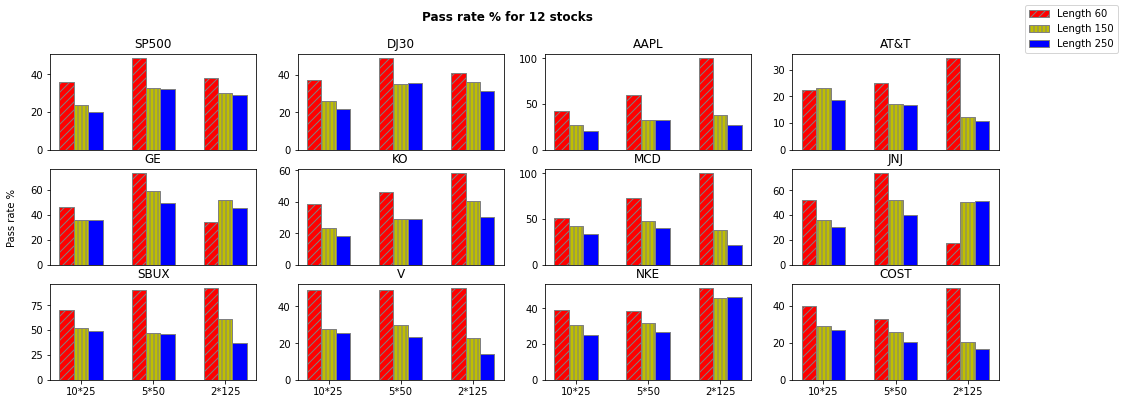

In [10]:
barWidth = 0.2
stock_ind = 0
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
labels = {"l60" : "Length 60", "l150" : "Length 150", 
          "l250" : "Length 250"}

fig, axis = plt.subplots(3,4,figsize=(17, 6)) 
for i in range(2):
    for j in range(4):
        cont_60 = [data_table[o][stock_ind]*100 for o in len_60]
        cont_150 = [data_table[o][stock_ind]*100 for o in len_150]
        cont_250 = [data_table[o][stock_ind]*100 for o in len_250]
        axis[i][j].bar(br1, cont_60, color ='r', width = barWidth,
                edgecolor ='grey', hatch='///',label =labels['l60'])
        labels['l60'] = "_nolegend_"
        axis[i][j].bar(br2, cont_150, color ='y', width = barWidth,
                edgecolor ='grey', hatch='|||', label =labels['l150'])
        labels['l150'] = "_nolegend_"
        axis[i][j].bar(br3, cont_250, color ='b', width = barWidth,
                edgecolor ='grey', label =labels['l250'])
        labels['l250'] = "_nolegend_"
        axis[i][j].set_xticks([])
        axis[i][j].set_title(data_table['stock'][stock_ind])
        stock_ind += 1

for k in range(4):
    cont_60 = [data_table[o][stock_ind]*100 for o in len_60]
    cont_150 = [data_table[o][stock_ind]*100 for o in len_150]
    cont_250 = [data_table[o][stock_ind]*100 for o in len_250]
    axis[2][k].bar(br1, cont_60, color ='r', width = barWidth,
            edgecolor ='grey', hatch='///',label =labels['l60'])
    labels['l60'] = "_nolegend_"
    axis[2][k].bar(br2, cont_150, color ='y', width = barWidth,
            edgecolor ='grey', hatch='|||', label =labels['l150'])
    labels['l150'] = "_nolegend_"
    axis[2][k].bar(br3, cont_250, color ='b', width = barWidth,
            edgecolor ='grey', label =labels['l250'])
    labels['l250'] = "_nolegend_"
    axis[2][k].set_title(data_table['stock'][stock_ind])
    axis[2][k].set_xticks([r + barWidth for r in range(len(cont_60))],
            ['10*25', '5*50', '2*125'])
    stock_ind += 1
    
fig.text(0.09, 0.5, 'Pass rate %', va='center', rotation='vertical')
fig.suptitle('Pass rate % for 12 stocks ', fontweight='bold')
fig.legend()
plt.savefig('Example_Pass_rate.jpg', dpi =300)
plt.show()